In [2]:
import pandas as pd
df = pd.read_csv('../../data/person_data_no_na.csv')

In [3]:
df.columns

Index(['V_TYPE', 'V_YEAR', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV', 'P_SAFE',
       'P_USER'],
      dtype='object')

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

numeric_features = [
    "V_YEAR", 
    "P_AGE"
]

categorical_features = [
    "V_TYPE",
    "P_SEX",
    "P_PSN",
    # "P_ISEV",
    "P_SAFE",
    "P_USER"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("nb", MultinomialNB())
])

X = df.drop("P_ISEV", axis=1)
y = df["P_ISEV"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.67      0.59    314927
           1       0.70      0.56      0.62    442587
           2       0.05      0.04      0.04      5103

    accuracy                           0.60    762617
   macro avg       0.42      0.42      0.42    762617
weighted avg       0.62      0.60      0.60    762617



### Random undersampling of nonfatal injuries and no injuries

In [5]:
num_fatality = df[df["P_ISEV"] == 2].shape[0]
num_fatal_injury = df[df["P_ISEV"] == 2].shape[0]
df_undersampled_0 = df[df["P_ISEV"] == 0].sample(n=num_fatality * 2, random_state=42)
df_undersampled_1 = df[df["P_ISEV"] == 1].sample(n=num_fatality * 2, random_state=42)
df_balanced = pd.concat([df[df["P_ISEV"] == 2], df_undersampled_0, df_undersampled_1])

X = df_balanced.drop("P_ISEV", axis=1)
y = df_balanced["P_ISEV"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42,     
    shuffle=True         
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.70      0.60     10358
           1       0.53      0.45      0.49     10147
           2       0.63      0.43      0.51      5119

    accuracy                           0.55     25624
   macro avg       0.57      0.53      0.53     25624
weighted avg       0.55      0.55      0.54     25624



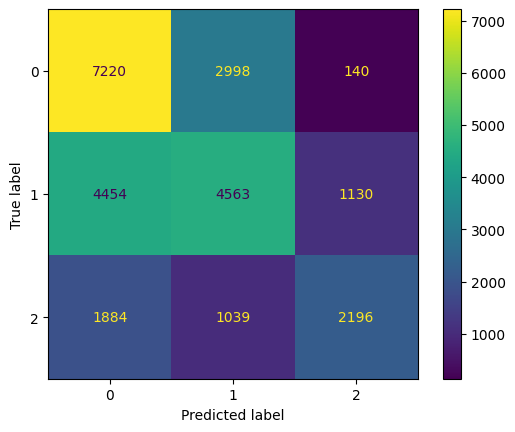

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

### Use sample weights as well

In [7]:
from sklearn.utils import compute_sample_weight


weights = compute_sample_weight(
    class_weight={0:1, 1:1, 2:4},  # increase weight of class 2
    y=y_train
)

model.fit(X_train, y_train, nb__sample_weight=weights)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.67      0.59     10358
           1       0.53      0.43      0.48     10147
           2       0.53      0.48      0.50      5119

    accuracy                           0.53     25624
   macro avg       0.53      0.52      0.52     25624
weighted avg       0.53      0.53      0.53     25624



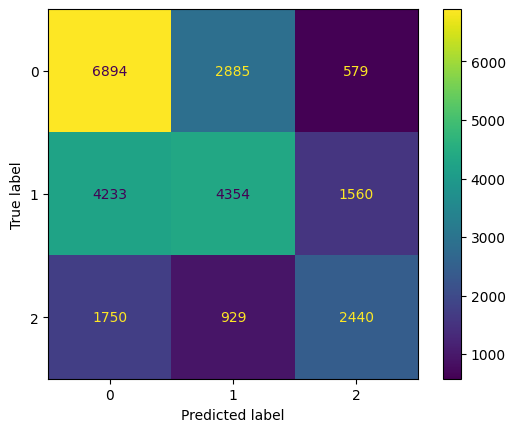

In [8]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## Feature importance

In [9]:
from sklearn.inspection import permutation_importance
feature_names = (
    numeric_features +
    categorical_features
)

r = permutation_importance(
    model, X, y,
    n_repeats=10,
    random_state=42
)

perm_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": r.importances_mean # type: ignore
}).sort_values("importance", ascending=False)

print(perm_importance_df)

  feature  importance
5  P_SAFE    0.083458
2  V_TYPE    0.053295
0  V_YEAR    0.029351
4   P_PSN    0.022809
6  P_USER    0.020048
3   P_SEX    0.000200
1   P_AGE    0.000146
